In [1]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight


In [2]:


# Define dataset path
dataset_path = "/kaggle/input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_dataset"

# Create empty lists for image paths and labels
image_paths = []
labels = []

# Loop through all subdirectories 
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    
    # Check if it's a directory 
    if os.path.isdir(class_folder):
        for filename in os.listdir(class_folder):
            if filename.endswith((".jpg", ".png")):  
                image_paths.append(os.path.join(class_folder, filename))
                labels.append(class_name)  

# Create DataFrame
df = pd.DataFrame({"image_path": image_paths, "label": labels})

# Shuffle dataset
df = df.sample(frac=1).reset_index(drop=True)

print(df.head()) 


                                          image_path             label
0  /kaggle/input/alzheimer-mri-4-classes-dataset/...       NonDemented
1  /kaggle/input/alzheimer-mri-4-classes-dataset/...       NonDemented
2  /kaggle/input/alzheimer-mri-4-classes-dataset/...       NonDemented
3  /kaggle/input/alzheimer-mri-4-classes-dataset/...  VeryMildDemented
4  /kaggle/input/alzheimer-mri-4-classes-dataset/...       NonDemented


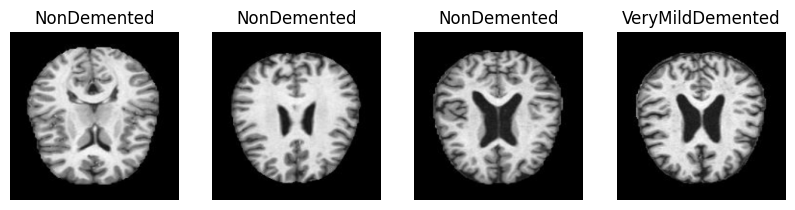

In [3]:
import matplotlib.pyplot as plt
import cv2

# Function to display images
def show_images(df, num_images=4, img_size=(224, 224)):
    plt.figure(figsize=(10, 5))

    for i in range(num_images):
        img_path = df.iloc[i]["image_path"]  
        img = cv2.imread(img_path)  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        img = cv2.resize(img, img_size)  
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(df.iloc[i]["label"])  
        plt.axis("off")  

    plt.show()

# Call function to display images
show_images(df, num_images=4)



In [4]:

IMG_SIZE = (224, 224)

# Function to load images from paths in df
def load_images(df):
    X, y = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["image_path"])  
        img = cv2.resize(img, IMG_SIZE)  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        X.append(img)
        y.append(row["label"])
    return np.array(X) / 255.0, np.array(y)  

# Load images from df
X, y = load_images(df)

# Convert labels to numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) 

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
print(f"Classes: {label_encoder.classes_}")  


Training samples: 4096, Testing samples: 1280
Classes: ['MildDemented' 'ModerateDemented' 'NonDemented' 'VeryMildDemented']


In [7]:


# Define CNN model
model = Sequential([
    # Convolutional Layer 1
    Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Convolutional Layer 3
    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Fully Connected Layers
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),  # Reduce overfitting
    Dense(128, activation="relu"),
    Dense(4, activation="softmax")  # 4 output classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Print model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,278,980 (84.99 MB)

 Trainable params: 22,278,532 (84.99 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  
    batch_size=32
)


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.4475 - loss: 2.9081 - val_accuracy: 0.3711 - val_loss: 1.9575
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.5175 - loss: 1.0129 - val_accuracy: 0.5361 - val_loss: 1.0519
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.5225 - loss: 0.9630 - val_accuracy: 0.5010 - val_loss: 1.0191
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.5357 - loss: 0.9072 - val_accuracy: 0.5137 - val_loss: 0.9032
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.5451 - loss: 0.8765 - val_accuracy: 0.6191 - val_loss: 0.7684
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.5426 - loss: 0.8515 - val_accuracy: 0.6680 - val_loss: 0.7117
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.5756 - loss: 0.8233 - val_accuracy: 0.7324 - val_loss: 0.6761
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.6007 - loss: 0.7936 - val_acc

# More complex model (another layer CN)

In [9]:
model = Sequential([
    # Convolutional Layer 1
    Conv2D(64, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Convolutional Layer 2
    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Convolutional Layer 3
    Conv2D(256, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Convolutional Layer 4
    Conv2D(512, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),  
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(4, activation="softmax")  
])


# Another optimizer (sgd with momentum)

In [15]:
optimizer = SGD(learning_rate=0.01, momentum=0.9)


# Compile new model

In [16]:
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


# Fit new model

In [17]:
history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=20,  
    batch_size=32
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 64s 361ms/step - accuracy: 0.4300 - loss: 8.6731 - val_accuracy: 0.4971 - val_loss: 1.0554
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 310ms/step - accuracy: 0.4962 - loss: 1.7933 - val_accuracy: 0.4971 - val_loss: 1.0335
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 309ms/step - accuracy: 0.4990 - loss: 1.0634 - val_accuracy: 0.4971 - val_loss: 1.0268
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 307ms/step - accuracy: 0.4978 - loss: 1.0587 - val_accuracy: 0.4971 - val_loss: 1.0249
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 311ms/step - accuracy: 0.4830 - loss: 1.0736 - val_accuracy: 0.4971 - val_loss: 1.0247
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 306ms/step - accuracy: 0.5017 - loss: 1.0525 - val_accuracy: 0.4971 - val_loss: 1.0241
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 309ms/step - accuracy: 0.4919 - loss: 1.0765 - val_accuracy: 0.4971 - val_loss: 1.0232
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 307ms/step - accuracy: 0.5144 - loss: 1.0747 - val

# Data augementation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)


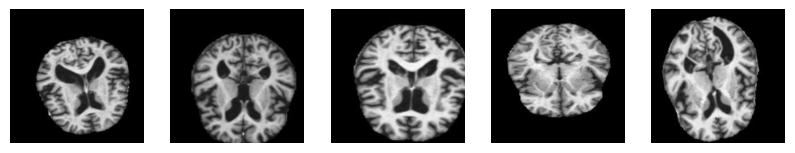

In [22]:
import matplotlib.pyplot as plt

# Get a batch of augmented images
augmented_images, labels = next(train_generator)

# Plot first 5 images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis("off")
plt.show()


# Transfer learning with ResNet50

In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(4, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
history = model.fit(train_generator, validation_data=(X_val, y_val), epochs=20, batch_size=32)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 61s 358ms/step - accuracy: 0.4404 - loss: 1.5060 - val_accuracy: 0.5273 - val_loss: 1.0102
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 43s 317ms/step - accuracy: 0.4639 - loss: 1.0883 - val_accuracy: 0.5273 - val_loss: 0.9999
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 43s 318ms/step - accuracy: 0.4830 - loss: 1.0725 - val_accuracy: 0.5273 - val_loss: 0.9973
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 43s 318ms/step - accuracy: 0.5048 - loss: 1.0664 - val_accuracy: 0.5273 - val_loss: 0.9977
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 43s 321ms/step - accuracy: 0.4919 - loss: 1.0663 - val_accuracy: 0.5273 - val_loss: 0.9882
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 43s 317ms/step - accuracy: 0.4862 - loss: 1.0943 - val_accuracy: 0.5273 - val_loss: 1.0084
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 43s 317ms/step - accuracy: 0.5019 - loss: 1.0577 - val_accuracy: 0.5273 - val_loss: 1.0007
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 43s 317ms/step - accuracy: 0.4941 - loss: 1.0644 - val

# Transfer learning

In [24]:

# Load Pretrained Model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  
# Custom Classifier
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(4, activation="softmax")(x)

# Compile Model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [25]:
history = model.fit(train_generator, validation_data=(X_val, y_val), epochs=20, batch_size=32)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 72s 367ms/step - accuracy: 0.4219 - loss: 1.3022 - val_accuracy: 0.5010 - val_loss: 1.0616
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 302ms/step - accuracy: 0.4626 - loss: 1.0587 - val_accuracy: 0.5010 - val_loss: 1.0542
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 306ms/step - accuracy: 0.4841 - loss: 1.0743 - val_accuracy: 0.5010 - val_loss: 1.0508
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 310ms/step - accuracy: 0.4732 - loss: 1.0625 - val_accuracy: 0.5010 - val_loss: 1.0624
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 305ms/step - accuracy: 0.4830 - loss: 1.0800 - val_accuracy: 0.5010 - val_loss: 1.0539
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 306ms/step - accuracy: 0.4648 - loss: 1.0783 - val_accuracy: 0.5010 - val_loss: 1.0528
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 302ms/step - accuracy: 0.4563 - loss: 1.0825 - val_accuracy: 0.5010 - val_loss: 1.0525
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 303ms/step - accuracy: 0.4788 - loss: 1.0631 - val